In [4]:
import skimage
print(skimage.__version__)

0.25.2


📂 Please choose a satellite/drone image to dehaze...
🧠 Processing image...
✅ Dehazed image saved as 'dehazed_output.jpg'


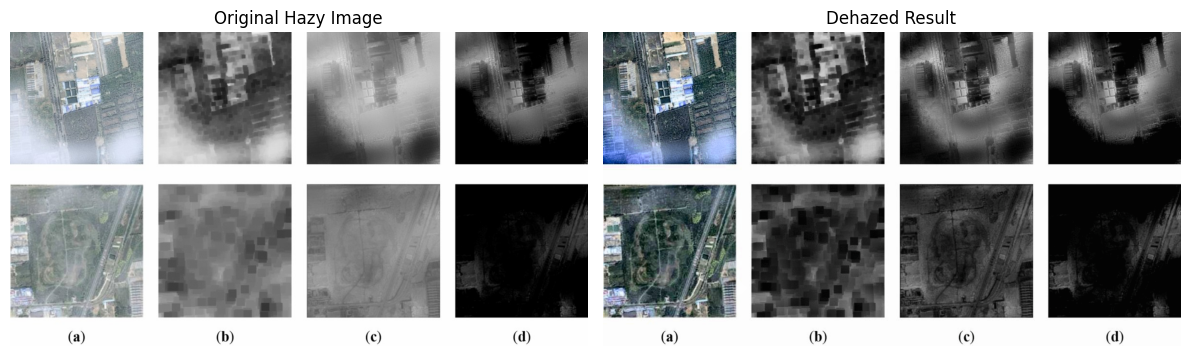

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog

# -------------------- Parameter presets based on haze density --------------------
PRESETS = {
    "thin":     {"window_size": 15, "omega": 0.75, "t0": 0.05, "percent": 0.0008},
    "moderate": {"window_size": 25, "omega": 0.85, "t0": 0.03, "percent": 0.0015},
    "thick":    {"window_size": 35, "omega": 1.00, "t0": 0.01, "percent": 0.0025}
}

# -------------------- 1. Dark Channel Estimation --------------------
def get_dark_channel(image, window_size):
    min_channel = np.min(image, axis=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (window_size, window_size))
    return cv2.erode(min_channel, kernel)

# -------------------- 2. Atmospheric Light Estimation --------------------
def estimate_atmospheric_light(image, dark_channel, top_percent):
    num_pixels = int(top_percent * dark_channel.size)
    indices = np.unravel_index(np.argsort(dark_channel.ravel())[-num_pixels:], dark_channel.shape)
    brightest = image[indices]
    A = np.max(brightest, axis=0)
    return A

# -------------------- 3. Transmission Map Calculation --------------------
def estimate_transmission(image, A, omega, window_size):
    normed = image / A
    dark_channel = get_dark_channel(normed, window_size)
    return 1 - omega * dark_channel

# -------------------- 4. Guided Filtering --------------------
def guided_filter(I, p, radius=40, eps=1e-3):
    mean_I = cv2.boxFilter(I, cv2.CV_64F, (radius, radius))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (radius, radius))
    corr_I = cv2.boxFilter(I * I, cv2.CV_64F, (radius, radius))
    corr_Ip = cv2.boxFilter(I * p, cv2.CV_64F, (radius, radius))

    var_I = corr_I - mean_I ** 2
    cov_Ip = corr_Ip - mean_I * mean_p

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (radius, radius))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (radius, radius))

    return mean_a * I + mean_b

# -------------------- 5. Haze-Free Image Recovery --------------------
def recover_image(image, transmission, A, t0):
    transmission = np.clip(transmission, t0, 1)[:, :, np.newaxis]
    J = (image - A) / transmission + A
    return np.clip(J, 0, 1)

# -------------------- 6. CLAHE Contrast Enhancement --------------------
def apply_clahe(image_rgb):
    lab = cv2.cvtColor((image_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    enhanced_lab = cv2.merge((l, a, b))
    enhanced_rgb = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    return enhanced_rgb / 255.0

# -------------------- Complete Dehazing Pipeline --------------------
def dehaze_adaptive_dcp(input_bgr, haze_level="thick"):
    params = PRESETS[haze_level]
    image_rgb = cv2.cvtColor(input_bgr, cv2.COLOR_BGR2RGB) / 255.0

    # Step 1
    dark_channel = get_dark_channel(image_rgb, params["window_size"])

    # Step 2
    A = estimate_atmospheric_light(image_rgb, dark_channel, params["percent"])

    # Step 3
    transmission = estimate_transmission(image_rgb, A, params["omega"], params["window_size"])

    # Step 4
    gray = cv2.cvtColor((image_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY) / 255.0
    transmission_refined = guided_filter(gray, transmission)

    # Step 5
    dehazed_rgb = recover_image(image_rgb, transmission_refined, A, params["t0"])

    # Step 6
    contrast_enhanced = apply_clahe(dehazed_rgb)

    return (contrast_enhanced * 255).astype(np.uint8)

# -------------------- Main Entry with File Dialog --------------------
if __name__ == "__main__":
    print("📂 Please choose a satellite/drone image to dehaze...")
    Tk().withdraw()  # Hide the root Tkinter window
    file_path = filedialog.askopenfilename(title="Select hazy satellite image")

    if not file_path:
        print("❌ No image selected.")
        exit()

    haze_level = "thick"  # You can change to "thin", "moderate", or "thick"
    input_img = cv2.imread(file_path)

    if input_img is None:
        raise FileNotFoundError(f"Image not found: {file_path}")

    print("🧠 Processing image...")
    result_img = dehaze_adaptive_dcp(input_img, haze_level)

    output_path = "dehazed_output.jpg"
    cv2.imwrite(output_path, cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR))
    print(f"✅ Dehazed image saved as '{output_path}'")

    # Show before/after comparison
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Hazy Image")
    plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Dehazed Result")
    plt.imshow(result_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
